In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import pickle as pkl

from sklearn.metrics import  classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [3]:
import importlib
import ids_common
importlib.reload(ids_common)

SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

SEED = 42


In [77]:
df_orig = pd.read_csv('./sampled_data/sample_1/eval_10_attack.csv', low_memory=False)

In [5]:
df_orig.shape

(26449, 61)

In [6]:
df_orig['Attack_label'].value_counts()

Attack_label
0    24045
1     2404
Name: count, dtype: int64

In [37]:
df_orig.sort_values(by=['Attack_label'], ignore_index=True, inplace=True)

In [39]:
X_test, y_test = ids_common.make_15_class(df_orig)

In [40]:
def measure_time(x_test, cls):
    class_time = []
    class_predicts = []
    for _, row in x_test.iterrows():
        t = time.time()
        # print(row)
        # class_15_xgb_predicts.append(class_15_xgb_xgb.predict(pd.DataFrame(row).T))
        class_predicts.append(cls.predict(row.to_numpy().reshape(1, -1)))

        class_time.append(time.time() - t)
    return class_time, class_predicts

def measure_time_cascade(x_test, detector, cls):
    class_casdade_time = []
    class_cascade_predicts = []
    for index, row in x_test.iterrows():
        t = time.time()
        record = row.to_numpy().reshape(1, -1)
        detection = detector.predict(record)

        if detection == 1:
            class_cascade_predicts.append(cls.predict(record))
        else:
            class_cascade_predicts.append(detection)
        
        class_casdade_time.append(time.time() - t)

    return class_casdade_time, class_cascade_predicts

def stats(method, tt, header=False):

   

    if header:
        print('{:<10}{:7}{:7}{:7}{:7}{:7}'.format('Method', 'Min', 'Max', 'Mean', 'Std', 'Total'))

    row = '{:<10}{:<7.3f}{:<7.3f}{:<7.3f}{:<7.3f}{:<7.3f}'
    
    print(row.format(method, np.min(tt), np.max(tt), np.mean(tt), np.std(tt), np.sum(tt)))
    # print(f'   min: {np.min(tt):0.5f}')
    # print(f'   max: {np.max(tt):0.5f}')
    # print(f'  mean: {np.mean(tt):0.5f}')
    # # print(f'median: {np.median(tt):0.5f}')
    # print(f'   std: {np.std(tt):0.5f}')
    # print(f' total: {np.sum(tt):0.5f}')

In [41]:
models = pkl.load(open('models.pkl', 'rb'))

class_15_xgb = models['class_15_xgb']
class_15_rf = models['class_15_rf']
class_2_dt = models['class_2_dt']
class_14_rf = models['class_14_rf']
class_14_xgb = models['class_14_xgb']

In [42]:
class_casdade_dt_rf_time, class_cascade_dt_rf_predicts = measure_time_cascade(X_test, class_2_dt, class_14_rf)

class_casdade_dt_xgb_time , class_cascade_dt_xgb_predicts = measure_time_cascade(X_test, class_2_dt, class_14_xgb)

class_15_xgb_time, class_15_xgb_predicts = measure_time(X_test, class_15_xgb)

class_15_rf_time, class_15_rf_predicts = measure_time(X_test, class_15_rf)


In [43]:
stats('XGB', class_15_xgb_time, header=True)
stats('RF', class_15_rf_time, header=False)
stats('DT-RF', class_casdade_dt_rf_time, header=False)
stats('DT-XGB', class_casdade_dt_xgb_time, header=False)

# shuffled
'''
Method    Min    Max    Mean   Std    Total  
XGB       0.000  0.008  0.000  0.001  10.960 
RF        0.002  0.010  0.003  0.000  83.236 
DT-RF     0.000  0.006  0.000  0.001  8.288  
DT-XGB    0.000  0.002  0.000  0.000  2.495  
'''

Method    Min    Max    Mean   Std    Total  
XGB       0.000  0.008  0.000  0.001  11.029 
RF        0.002  0.011  0.003  0.000  84.599 
DT-RF     0.000  0.094  0.000  0.001  8.315  
DT-XGB    0.000  0.002  0.000  0.000  2.055  


'\nMethod    Min    Max    Mean   Std    Total  \nXGB       0.000  0.008  0.000  0.001  10.960 \nRF        0.002  0.010  0.003  0.000  83.236 \nDT-RF     0.000  0.006  0.000  0.001  8.288  \nDT-XGB    0.000  0.002  0.000  0.000  2.495  \n'

In [50]:
rf_ = class_15_rf_time.copy()
xgb_ = class_15_xgb_time.copy()
dt_rf = class_casdade_dt_rf_time.copy()
dt_xgb = class_casdade_dt_xgb_time.copy()

In [51]:
print(list(map(len, [rf_, xgb_, dt_rf, dt_xgb])))

[26449, 26449, 26449, 26449]


[26448, 26448, 26448, 26448]


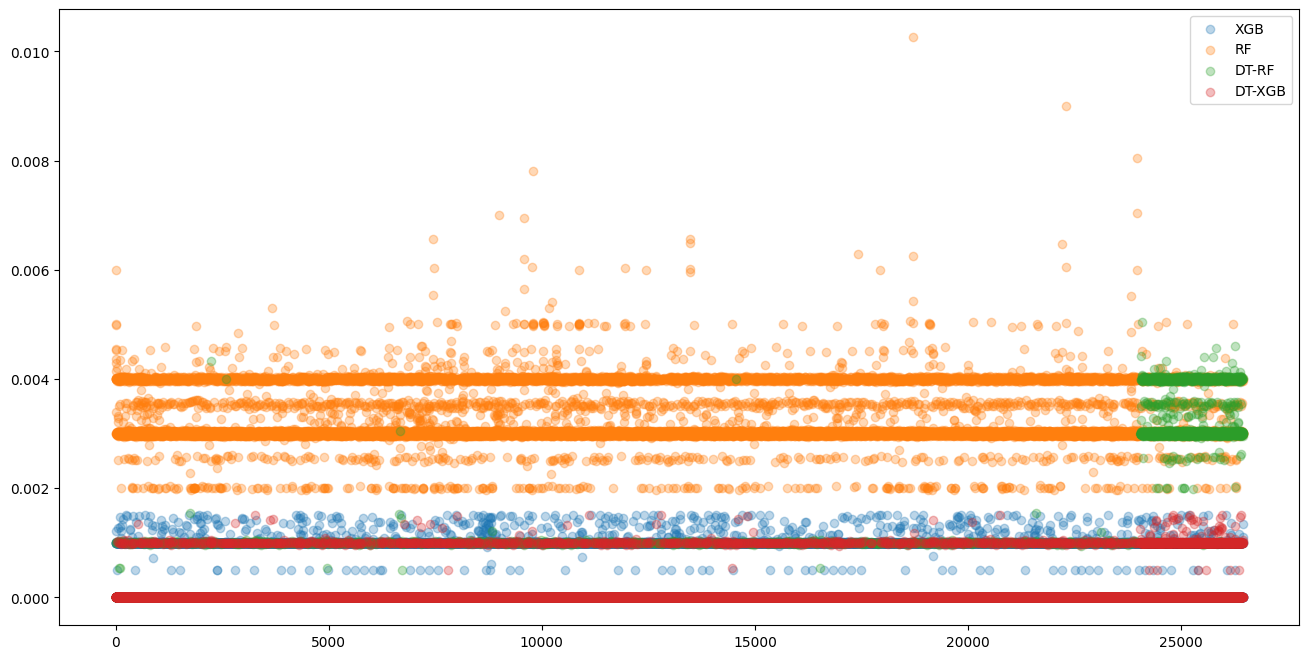

In [52]:


rf_.remove(max(rf_))
xgb_.remove(max(xgb_))
dt_rf.remove(max(dt_rf))
dt_xgb.remove(max(dt_xgb))

print(list(map(len, [rf_, xgb_, dt_rf, dt_xgb])))
xs = list(range(len(xgb_)))

plt.figure(figsize=(16, 8))

plt.scatter(x=xs, y=xgb_, alpha=0.3, label='XGB')
plt.scatter(x=xs, y=rf_, alpha=0.3, label='RF')
plt.scatter(x=xs, y=dt_rf, alpha=0.3, label='DT-RF')
plt.scatter(x=xs, y=dt_xgb, alpha=0.3, label='DT-XGB')
plt.legend()

In [201]:
df_50prcnt = pd.read_csv('./sampled_data/sample_1/clean_ml_sample_balanced_2_class.csv', low_memory=False)

In [202]:
df_train, df_test = ids_common.ds_split(df_50prcnt, seed=42)

In [203]:
df_test = pd.concat([df_test[df_test['Attack_label']==0].sample(n=9000), 
                df_test[df_test['Attack_label']==1].sample(n=1000)])

In [204]:
X_test, y_test = ids_common.make_15_class(df_test)

In [205]:
X_test.shape

(10000, 59)

In [206]:
# X_test, y_test = ids_common.make_15_class(ddf_test)

t = time.time()
y_class_15_predict = class_15_rf.predict(X_test)
print(f'prediction time {class_15_rf.__class__.__name__}: {time.time()-t}')
# print(classification_report(y_test, le_15.inverse_transform(y_class_15_predict)))

t = time.time()
y_class_15_predict = class_15_xgb.predict(X_test)
print(f'prediction time {class_15_xgb.__class__.__name__}: {time.time()-t}')
# print(classification_report(y_test, le_15.inverse_transform(y_class_15_predict)))

prediction time RandomForestClassifier: 0.14405298233032227
prediction time XGBClassifier: 0.03534364700317383


In [167]:
# X_test, y_test = ids_common.make_15_class(ddf_test)

detector = class_2_dt
classifier = class_14_rf

t_prediction = 0
t = time.time()
y_class_2_predict = detector.predict(X_test)
t_prediction += time.time()-t


ds_class_14 = df_test[y_class_2_predict==1]
X_class_14 = ds_class_14.drop(
                [ids_common.target_label_2_class, 
                ids_common.target_label_15_class], 
                axis=1, inplace=False)

t = time.time()
y_class_14_predict = classifier.predict(X_class_14)
t_prediction += time.time()-t

print(f'prediction time {detector.__class__.__name__}+{classifier.__class__.__name__}: {t_prediction}')


detector = class_2_dt
classifier = class_14_xgb

t_prediction = 0
t = time.time()
y_class_2_predict = detector.predict(X_test)
t_prediction += time.time()-t


ds_class_14 = df_test[y_class_2_predict==1]
X_class_14 = ds_class_14.drop(
                [ids_common.target_label_2_class, 
                ids_common.target_label_15_class], 
                axis=1, inplace=False)

t = time.time()
y_class_14_predict = classifier.predict(X_class_14)
t_prediction += time.time()-t

print(f'prediction time {detector.__class__.__name__}+{classifier.__class__.__name__}: {t_prediction}')

prediction time DecisionTreeClassifier+RandomForestClassifier: 0.024001359939575195
prediction time DecisionTreeClassifier+XGBClassifier: 0.007999181747436523


In [207]:
df_50prcnt = pd.read_csv('./sampled_data/sample_1/clean_ml_sample_balanced_2_class.csv', low_memory=False)
df_train, df_test = ids_common.ds_split(df_50prcnt, seed=42)
df_test = pd.concat([df_test[df_test['Attack_label']==0].sample(n=9000), 
                df_test[df_test['Attack_label']==1].sample(n=1000)])
X_test, y_test = ids_common.make_15_class(df_test)

In [208]:
class_casdade_dt_rf_time, class_cascade_dt_rf_predicts = measure_time_cascade(X_test, class_2_dt, class_14_rf)

class_casdade_dt_xgb_time , class_cascade_dt_xgb_predicts = measure_time_cascade(X_test, class_2_dt, class_14_xgb)

class_15_xgb_time, class_15_xgb_predicts = measure_time(X_test, class_15_xgb)

class_15_rf_time, class_15_rf_predicts = measure_time(X_test, class_15_rf)

In [211]:

stats('RF', class_15_rf_time, header=True)
stats('XGB', class_15_xgb_time, header=False)
stats('DT-RF', class_casdade_dt_rf_time, header=False)
stats('DT-XGB', class_casdade_dt_xgb_time, header=False)

Method    Min    Max    Mean   Std    Total  
RF        0.002  0.013  0.003  0.000  31.394 
XGB       0.000  0.002  0.000  0.001  4.256  
DT-RF     0.000  0.006  0.000  0.001  3.373  
DT-XGB    0.000  0.002  0.000  0.000  0.821  


In [195]:
rf_ = class_15_rf_time.copy()
xgb_ = class_15_xgb_time.copy()
dt_rf = class_casdade_dt_rf_time.copy()
dt_xgb = class_casdade_dt_xgb_time.copy()

10100


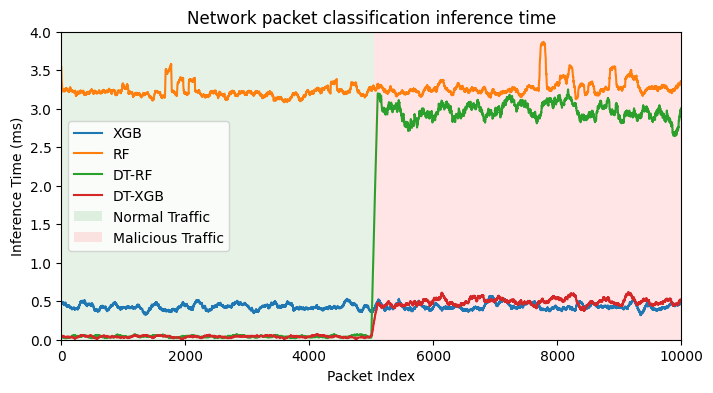

In [198]:
# Figure [evaluation graph]	

rf_ = class_15_rf_time.copy()
xgb_ = class_15_xgb_time.copy()
dt_rf = class_casdade_dt_rf_time.copy()
dt_xgb = class_casdade_dt_xgb_time.copy()

rf_.remove(max(rf_))
xgb_.remove(max(xgb_))
dt_rf.remove(max(dt_rf))
dt_xgb.remove(max(dt_xgb))

# print(list(map(len, [rf_, xgb_, dt_rf, dt_xgb])))

rf_ = np.convolve(rf_, np.ones(100)/100, mode='valid')*1000
xgb_ = np.convolve(xgb_, np.ones(100)/100, mode='valid')*1000
dt_rf = np.convolve(dt_rf, np.ones(100)/100, mode='valid')*1000
dt_xgb = np.convolve(dt_xgb, np.ones(100)/100, mode='valid')*1000


xs = list(range(len(xgb_)))
print(len(xs))
plt.figure(figsize=(8, 4))

plt.xlim(0, 10000)
plt.ylim(0, 4)

# plt.scatter(x=xs, y=xgb_, alpha=0.3, label='XGB')
# plt.scatter(x=xs, y=rf_, alpha=0.3, label='RF')
# plt.scatter(x=xs, y=dt_rf, alpha=0.3, label='DT-RF')
# plt.scatter(x=xs, y=dt_xgb, alpha=0.3, label='DT-XGB')



plt.plot(xgb_, alpha=1, label='XGB')
plt.plot(rf_, alpha=1, label='RF')
plt.plot(dt_rf, alpha=1, label='DT-RF')
plt.plot(dt_xgb, alpha=1, label='DT-XGB')

plt.axvspan(0, len(xs)//2, facecolor='g', alpha=0.1, label='Normal Traffic')
plt.axvspan(len(xs)//2, 10000, facecolor='r', alpha=0.1, label='Malicious Traffic')

plt.title('Network packet classification inference time')
plt.xlabel('Packet Index')
plt.ylabel('Inference Time (ms)')

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off

plt.legend()